# AdventureWorks försäljningsanalys

## Introduktion

Denna rapport presenterar en omfattande analys av försäljningsdata från AdventureWorks, ett fiktivt cykelföretag, baserat på databasen AdventureWorks2025. 

**Syfte**  
Syftet med analysen är att besvara centrala affärsfrågor kring företagets försäljning genom att hämta och bearbeta data från SQL Server med Python, samt visualisera resultaten i tydliga diagram. Målet är att omvandla rådata till insikter som kan användas som underlag för strategiska beslut.

De obligatoriska delarna fokuserar på sju nyckelområden: produktantal och intäkter per kategori, försäljningstrender över tid, topp-presterande produkter, regionala skillnader samt genomsnittligt ordervärde per region och kundtyp. 

För VG-nivå har Alternativ A – Regional försäljningsoptimering - lagts till, där prestanda per region undersökts närmare med fokus på bästa/sämsta regioner, produktkategoriernas fördelning samt säsongsmönster. 

Analysen syftar till att ge konkreta insikter och rekommendationer som kan stödja strategiska beslut kring sortiment, marknadsföring, lagerhantering och regional satsning.

---

## Setup Code

In [ ]:
# Importer biblotek
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus
import seaborn as sns

# Inloggningsuppgifter och anslutningsinställningar för SQL Server
user = "SA"
password = quote_plus("Lejonkatt123!")
server = 'localhost:1434'
database = 'AdventureWorks2025'
driver = quote_plus("ODBC Driver 18 for SQL server")

# Skapar en connection string för anslutning till SQL Server via SQLAlchemy och pyodbc
connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

# Skapar en SQLAlchemy engine som används för alla databasfrågor
engine = create_engine(connection_string)

# Testar anslutningen till databasen för att säkerställa att allt fungerar
try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


C:\Users\shara\AppData\Local\Temp\ipykernel_14240\1321093641.py:24: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


## Funktioner

In [ ]:
# Kör en SQL-fråga mot databasen och returnerar resultatet som en pandas DataFrame
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)
    
# Formaterar ett tal till ett mer lättläst format (K för tusental, M för miljoner)
def format_number(value):
    if value >= 1_000_000:
        return f'{value/1_000_000:.1f} M'
    elif value >= 1_000:
        return f'{value/1_000:.1f} K'
    else: 
        return f'{int(value)}' 

# Lägger till värdeetiketter på staplar i ett stapeldiagram (stående eller liggande)
def autolabel_bars(ax, bars,orientation='vertical', y_offset=1, x_offset=0,):
    
    # Loopar igenom varje stapel och placerar etiketten baserat på diagramtyp
    for bar in bars:
        if orientation == 'vertical':
            value = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2 + x_offset,
                value + y_offset,
                format_number(value),
                ha= 'center',
                va='bottom',
                fontsize=10,
                fontweight='medium'
            )
        else: # Horisontella staplar
            value = bar.get_width()
            ax.text(
                value + y_offset,
                bar.get_y() + bar.get_height() / 2 + x_offset,
                format_number(value),
                ha='left',
                va='center',
                fontsize=10,
                fontweight='medium'
            )


## Analys 1 - Antal produkter per kategori
**Affärsfråga: Hur många produkter finns i varje kategori?**

Tabeller som används: Production.ProductCategory, Production.ProductSubcategory, Production.Product

**Plan**
1. JOINA tabellerna för att hämta Kategorinamn och räkna antal unika ProductID inom varje kategori
2. Göra om min Query till en Dataframe
3. Visualisera resultatet med vertikalt stapeldiagram med etiketter ovanför varje stapel
4. Analysera resultatet - Krav på insikt: **Förklara vilken kategori som har flest/minst produkter.**

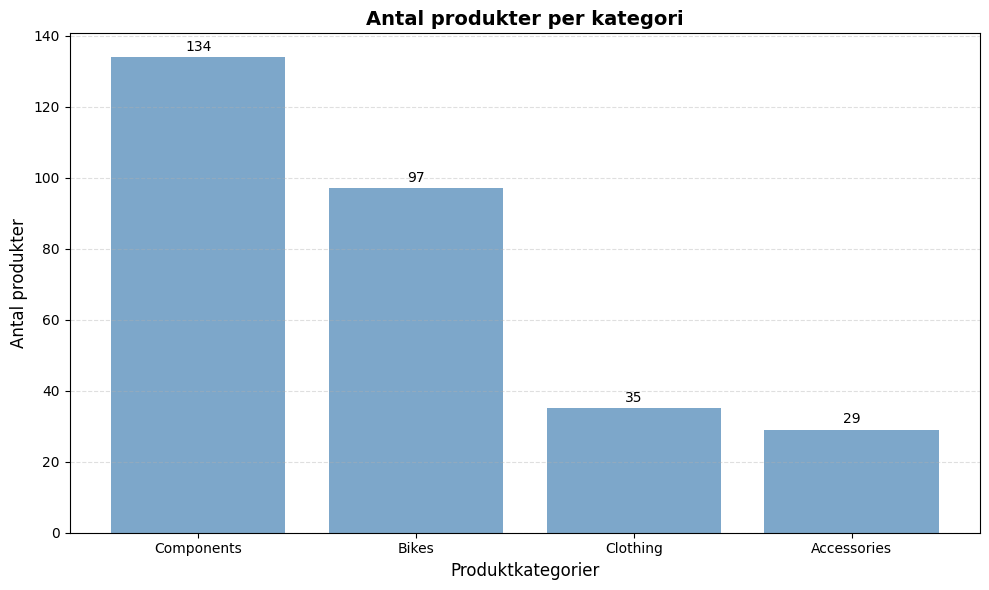

In [ ]:
# SQL-fråga: Räknar unika produkter per kategori
query_vis1 = """
SELECT
    pc.Name AS CategoryName,
    COUNT(DISTINCT p.ProductID) AS ProductCount
FROM Production.ProductCategory pc 
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC
"""

# Kör SQL-frågan och lagrar resultatet i en DataFrame
df_vis1 = query_df(query_vis1)

# Skapar vertikalt stapeldiagram
fig, ax = plt.subplots(figsize=(10,6))
bars = ax.bar(df_vis1['CategoryName'], df_vis1['ProductCount'], color='steelblue', alpha=0.7)

# Lägger värdeetiketter ovanpå staplarna
autolabel_bars(ax, bars, orientation= 'vertical')

# Titel, ettiketter och layout
ax.set_title('Antal produkter per kategori', fontsize=14, fontweight='bold')
ax.set_xlabel('Produktkategorier',fontsize=12)
ax.set_ylabel('Antal produkter', fontsize=12 )
ax.grid(axis='y',linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### Insikter - Antal produkter per kategori
Resultatet visar att **Components** har flest produkter (134). Detta tyder på att Adventure Works har ett brett sortiment av komponenter, vilket är rimligt för ett cykelföretag där delar som ramar, pedaler och andra komponenter är viktiga för både anpassning och underhåll av cyklar. Det kan även indikera ett tydligt fokus på reparationer och uppgraderingar, vilket i sin tur kan bidra till återkommande försäljning.

Kategorin **Accessories** har istället det minsta antalet produkter (29) vilket antyder att tillbehör som exempelvis hjälmar inte är ett lika prioriterat område. Genom att bredda sortimentet inom både kläder och accessoarer skulle företaget kunna skapa bättre möjligheter till merförsäljning och kompletterande köp.

---

## Analys 2 - Försäljning per produktkategori
**Affärsfråga: Vilka produktkategorier genererar mest intäkter?**

Tabeller som används: Production.ProductCategory, Production.ProductSubcategory, Production.Product, Sales.SalesOrderDetail

**Plan**
1. JOINA tabellerna för att hämta Kategorinamn och räkna ut totalsumman av ordrar inom varje kategori
2. Göra om min Query till en Dataframe
3. Visualisera resultatet med horisontellt stapeldiagram, sortera från högst till lägst (högsta överst)
4. Skriva ut största och minsta kategori med exakta siffror då detta är en del av kravet
5. Analysera resultatet - Krav på insikt: **Förklara vilken kategori som är störst och minst, med exakta siffror.**

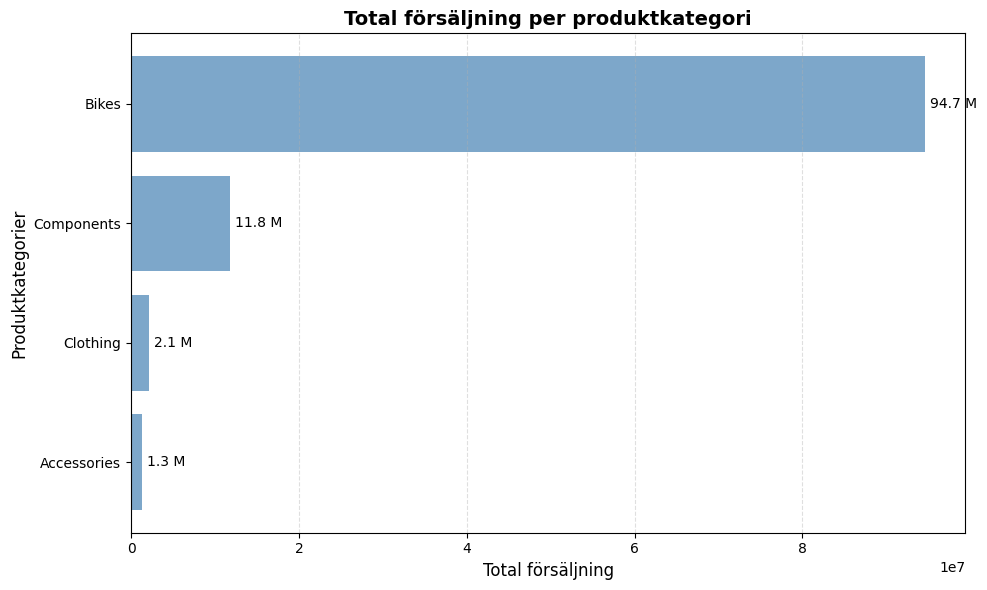

Största kategori: Bikes med totala försäljningen: $ 94,651,172.704731
Minsta kategori: Accessories med totala försäljningen: $ 1,272,072.883926


In [ ]:
# SQL-fråga: Total försäljning per kategori
query_vis2 = """
SELECT
    pc.Name AS CategoryName,
    SUM(sod.LineTotal) AS TotalSales
FROM Production.ProductCategory pc 
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
INNER JOIN Sales.SalesOrderDetail sod ON p.ProductID = sod.ProductID 
GROUP BY pc.Name
ORDER BY TotalSales DESC 
"""

# Kör SQL-frågan och lagrar resultatet i en DataFrame
df_vis2 = query_df(query_vis2)

# Skapar ett horisontellt stapeldiagram
fig, ax = plt.subplots(figsize=(10,6))
bars = ax.barh(df_vis2['CategoryName'][::-1], df_vis2['TotalSales'][::-1], color='steelblue', alpha=0.7)

# Lägger värdeetiketter bredvid staplarna
autolabel_bars(ax, bars, orientation= 'horizontal', y_offset=600_000)

# Titel, etiketter och layout
ax.set_title('Total försäljning per produktkategori', fontsize=14, fontweight='bold')
ax.set_xlabel('Total försäljning',fontsize=12)
ax.set_ylabel('Produktkategorier', fontsize=12 )
ax.grid(axis='x',linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Printar exakta siffror för analysdelen
print(f"Största kategori: {df_vis2.iloc[0]['CategoryName']} med totala försäljningen: $ {df_vis2.iloc[0]['TotalSales']:,}")
print(f"Minsta kategori: {df_vis2.iloc[-1]['CategoryName']} med totala försäljningen: $ {df_vis2.iloc[-1]['TotalSales']:,}")

### Insikter - Försäljning per produktkategori
Den klart strörsta produktkategorin är **Bikes** med en total försäljning på ca **$94,7 M**.   
Detta visar att cykelförsäljningen är kärnan i AdventureWorks verksamhet och den främsta intäktskällan.  
Samtidigt innebär det att företaget är relativt beroende av denna kategori, vilket gör att förändringar i efterfrågan på cyklar – exempelvis på grund av säsong eller konkurrens – kan få stor påverkan på det totala resultatet.

Den kategorin som genererar minst i försäljning är **Accessories** med en total omstättning på ca **$1,3 M**. Detta indikerar att tillbehör i nuläget utgör en mycket liten andel av företagets totala intäkter. Det kan även ses som en potentiell utvecklingsmöjlighet, där ett bredare sortiment eller ökad marknadsföring skulle kunna bidra till högre försäljning inom denna kategori.  

---

## Analys 3 - Försäljningstrend över tid
**Affärsfråga: Hur har försäljningen utvecklats över tid?**

Tabeller som används: Sales.SalesOrderHeader

**Plan**
1. Formatera om 'Orderdate' så det går att gruppera på månad samt summera totalförsäljning
2. Göra om min Query till en Dataframe
3. Visualisera resultatet med linjediagram
4. Skriv ut månaderna med största/minsta totala försäljning
5. Visualisera med ytterligre ett linjediagram för att göra säsongsaspekterna tydligare
6. Analysera resultatet - Krav på insikt: **Beskriv trenden - ökar den, minskar den, är den säsongsberoende? Nämn högsta och lägsta månaden.**

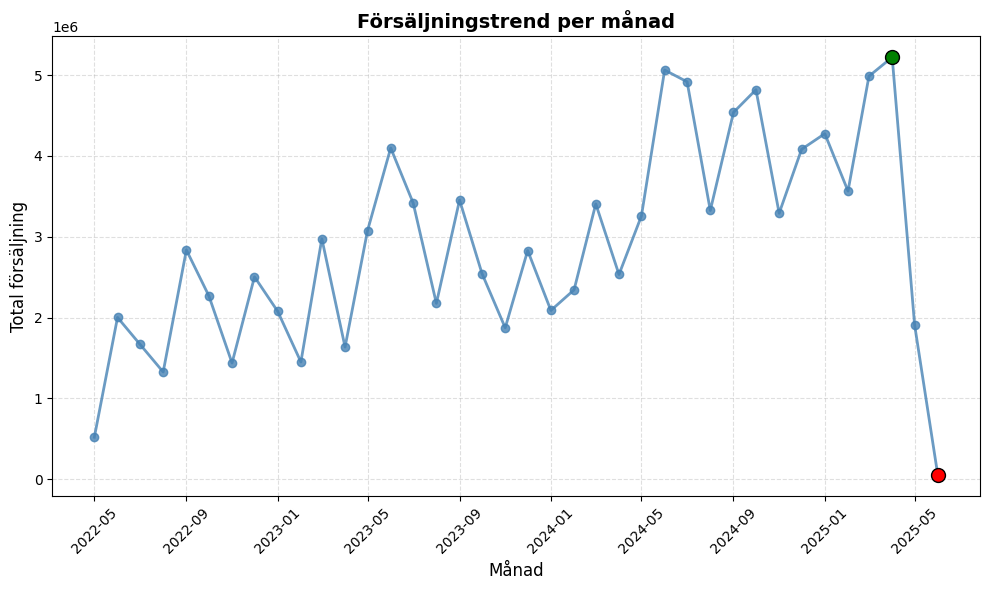

Högsta försäljningen inträffade: April-2025 med totala försäljningen: $ 5,222,759
Minsta försäljningen inträffade: June-2025 med totala försäljningen: $ 47,492


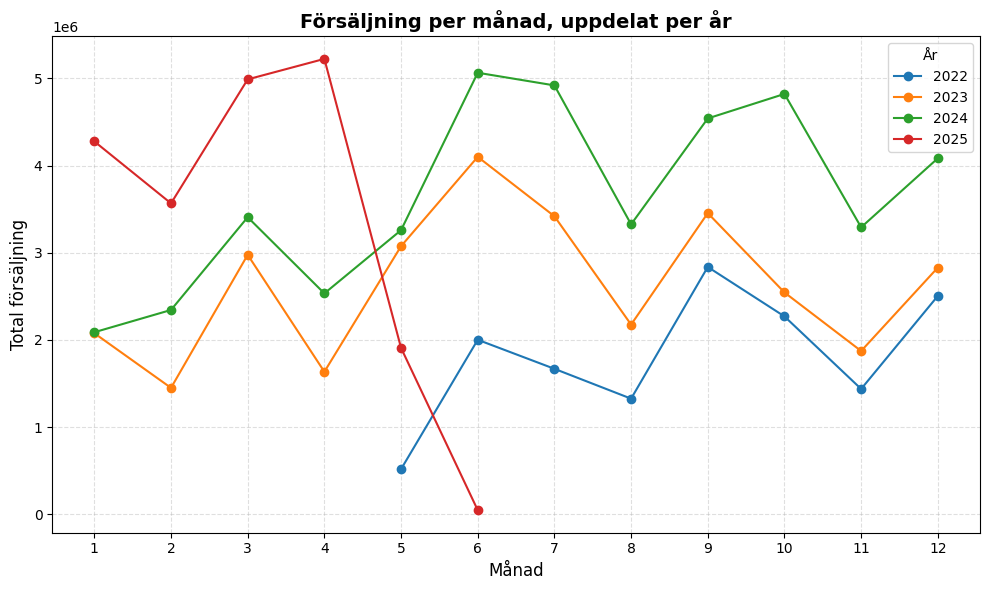

In [ ]:
# SQL-fråga: Total försäljning per månad
query_vis3 = """
SELECT
    DATEFROMPARTS(YEAR(OrderDate), MONTH(OrderDate), 1) AS YearMonth,
    SUM(SubTotal) AS TotalSales
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate), MONTH(OrderDate)
ORDER BY YearMonth
"""

# Kör SQL-frågan och lagrar resultatet i en DataFrame
df_vis3 = query_df(query_vis3)

# Identifierar månaderna med högst respektive lägst total försäljning
max_row = df_vis3.loc[df_vis3['TotalSales'].idxmax()]
min_row = df_vis3.loc[df_vis3['TotalSales'].idxmin()]

# Skapar linjediagram över tid
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(df_vis3['YearMonth'], df_vis3['TotalSales'], color='steelblue', linewidth=2, marker='o',alpha=0.8)

# Markera högsta (grön) och lägsta (röd) försäljningspunkt
ax.scatter(max_row['YearMonth'], max_row['TotalSales'], color='green', edgecolors='black', s=100, zorder=5)
ax.scatter(min_row['YearMonth'], min_row['TotalSales'], color='red', edgecolors='black', s=100, zorder=5)

# Titel, etiketter och layout
ax.set_title('Försäljningstrend per månad', fontsize=14, fontweight='bold')
ax.set_xlabel('Månad',fontsize=12)
ax.set_ylabel('Total försäljning', fontsize=12 )
ax.grid(True,linestyle='--', alpha=0.4)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Skriver ut vilken månad som hade högst respektive lägst försäljning
print(f"Högsta försäljningen inträffade: {max_row['YearMonth'].strftime('%B-%Y')} med totala försäljningen: $ {max_row['TotalSales']:,.0f}")
print(f"Minsta försäljningen inträffade: {min_row['YearMonth'].strftime('%B-%Y')} med totala försäljningen: $ {min_row['TotalSales']:,.0f}")

# Förbereder data för att analysera säsongsmönster genom att dela upp datum i år och månad
df_vis3['YearMonth'] = pd.to_datetime(df_vis3['YearMonth'])
df_vis3['Year'] = df_vis3['YearMonth'].dt.year
df_vis3['Month'] = df_vis3['YearMonth'].dt.month

# Skapar ett linjediagram som jämför försäljning per månad mellan olika år
fig, ax = plt.subplots(figsize=(10,6))
for year in sorted(df_vis3['Year'].unique()):
    df_year = df_vis3[df_vis3['Year'] == year]
    ax.plot(
        df_year['Month'],
        df_year['TotalSales'],
        marker='o',
        label=str(year)
    )

# Titel, etiketter och layout
ax.set_title("Försäljning per månad, uppdelat per år", fontsize=14, fontweight='bold')
ax.set_xlabel("Månad", fontsize=12)
ax.set_ylabel("Total försäljning", fontsize=12)
ax.set_xticks(range(1,13))  # 1-12 månader
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend(title='År')
plt.tight_layout()
plt.show()

### Insikter - Försäljningstrend över tid
**Övergripande trend**  
Försäljningen visar en tydlig **stigande** trend över perioden från mitten av 2022 till början av 2025. Det innebär att AdventureWorks har ökat sin försäljning över tid, vilket är positivt för företagets utveckling.

**Säsongsvariationer**  
I båda graferna syns tydliga **säsongsmönster** med regelbundna toppar och dalar under varje år.
Vanligtvis är det högre försäljning under vår/sommar och i slutet av året – troligen kopplat till vädersäsong + julhandel.

**Högsta och lägsta månad**  
Högsta försäljningen inträffade i början av 2025 (markerad med grön punkt i första grafen), med över 5 miljoner dollar i försäljning.
Lägsta försäljningen skedde i mitten av 2025 (markerad med röd punkt), med en försäljning på endast ca 47 000 dollar. (Vilket kan beror på att datan där är ofullständig.)

**Observationer/avvikelser**  
Den plötsliga "kollapsen" 2025 är alarmerande och avviker helt från tidigare mönster. Detta kan indikera externa faktorer (t.ex. lågkonjektur, leveransproblem) eller interna problem (t.ex datakvalitetsfel) För att kunna analysera datan vidare behövs ytterligare en utredning.

---

## Analys 4 - Försäljning och antal ordrar per år
**Affärsfråga: Hur ser total försäljning och antal ordrar ut per år?**

Tabeller som används: Sales.SalesOrderHeader

**Plan**
1. Formatera om 'Orderdate' så det går att gruppera på år samt summera totalförsäljning och räkna unika ordrar.
2. Göra om min Query till en Dataframe
3. Visualisera resultatet med grupperat stapeldiagram som använder två y-axlar, en för antal ordrar och en för total försäljning, för att hantera olika skalor.  
4. Analysera resultatet - Krav på insikt: **Jämför åren - vilket år hade högst försäljning? Ökar både försäljning OCH antal ordrar, eller bara det ena?.**

,OrderYear,TotalOrder,TotalSales
0,2022,1692,"14,561,052"
1,2023,3830,"31,604,922"
2,2024,14244,"43,671,890"
3,2025,11699,"20,008,518"


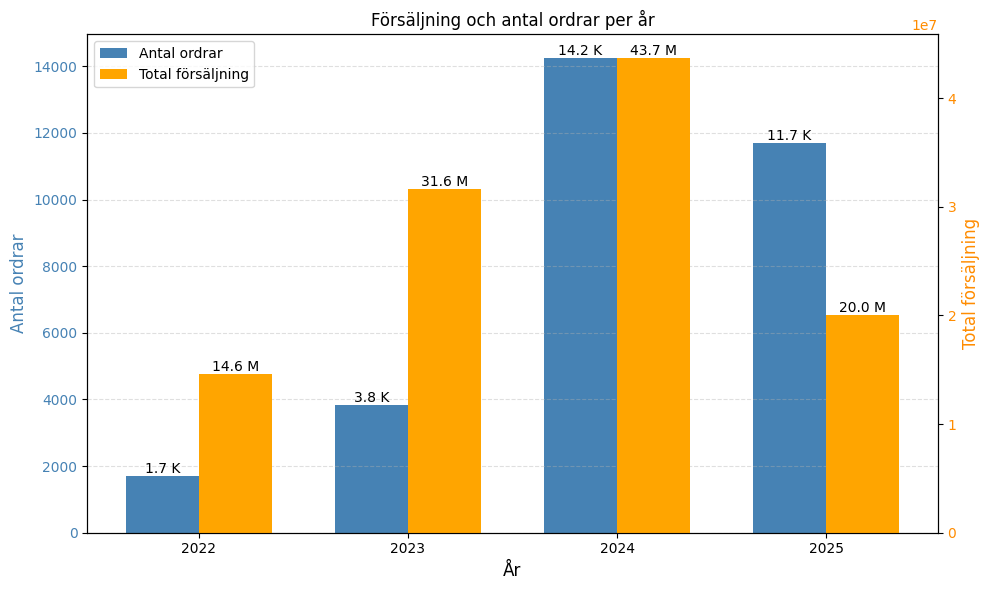

In [ ]:
# SQL-fråga: Total försäljning och antal unika ordrar per år
query_vis4 = """
SELECT
    YEAR(OrderDate) AS OrderYear,
    COUNT(DISTINCT SalesOrderID) AS TotalOrder,
    SUM(SubTotal) AS TotalSales
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate)
ORDER BY OrderYear
"""
# Kör SQL-frågan och lagrar resultatet i en DataFrame
df_vis4 = query_df(query_vis4)

# Skapar en kopia för snyggare visning av siffror i tabellen
df_vis4_display = df_vis4.copy()
df_vis4_display['TotalSales'] = df_vis4_display['TotalSales'].round(0).astype(int).map('{:,.0f}'.format)
display(df_vis4_display)

# Data för diagrammet
years = df_vis4['OrderYear']        # x-axeln
orders = df_vis4['TotalOrder']      # Stapel 1 "Antal ordrar"
sales = df_vis4['TotalSales']       # Stapel 2 "total försäljning"

# Positioner för grupperade staplar
x = np.arange(len(years))
width = 0.35

# Skapa diagram med två y-axlar (olika skalor)
fig, ax1 = plt.subplots(figsize=(10,6))

# Stapel 1 – Antal ordrar (vänster y-axel)
bars_order = ax1.bar(x - width/2, orders, width, label='Antal ordrar', color='steelblue')
ax1.set_xlabel('År', fontsize=12)
ax1.set_ylabel('Antal ordrar', color='steelblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.set_xticks(x)
ax1.set_xticklabels(years)
ax1.grid(axis='y', linestyle='--', alpha=0.4)

# Stapel 2 – Total försäljning (höger y-axel)
ax2 = ax1.twinx()
bars_sales = ax2.bar(x + width/2, sales, width, label='Total försäljning', color='orange')
ax2.set_ylabel('Total försäljning', color='darkorange', fontsize=12)
ax2.tick_params(axis='y', labelcolor='darkorange')

# Lägger värdeetiketter ovanpå staplarna
autolabel_bars(ax1, bars_order, orientation='vertical')
autolabel_bars(ax2, bars_sales, orientation='vertical')

# Legend – kombinerar båda axlarna
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Titel och layout
plt.title('Försäljning och antal ordrar per år')
plt.tight_layout()
plt.show()

### Insikter - Försäljning och antal ordrar per år

Diagrammet visar utvecklingen av både antal ordrar och total försäljning per år.
Både försäljning och antal ordrar ökar från 2022 till 2024, vilket indikerar en
tydlig tillväxtperiod för AdventureWorks.

År 2024 sticker ut som det starkaste året med både högst antal ordrar och högst
total försäljning. Under 2025 syns däremot en minskning i både försäljning och
antal ordrar jämfört med 2024, vilket kan tyda på en avmattning eller att året
inte är komplett.

Försäljningen ökar proportionellt mer än antalet ordrar mellan 2022 och 2024,
vilket kan indikera att det genomsnittliga ordervärdet har ökat. Detta tyder på
att företaget inte bara säljer mer, utan även lyckas generera högre intäkter per
order.

---

## Analys 5 -  Top 10 produkter
**Affärsfråga:  Vilka 10 produkter genererar mest försäljning?**

Tabeller som används: Production.Product, Sales.SalesOrderDetail, Production.ProductSubcategory, Production.ProductCategory.

**Plan**
1. JOINA tabellerna för att räkna ut totala försäljningssumman per produkt samt ta fram kategorinamn. Sortera i decending för att visa "Top 10" bäst säljande produkter
2. Göra om min Query till en Dataframe
3. Visualisera resultatet med Horisontellt stapeldiagram
4. Skriva ut Nr 1 med exakt försäljningsvärde samt vilken kategori som dominerar top 10
4. Analysera resultatet - Krav på insikt: **Nämn #1 produkten med exakt försäljningsvärde. Vilken kategori dominerar topp 10?.**

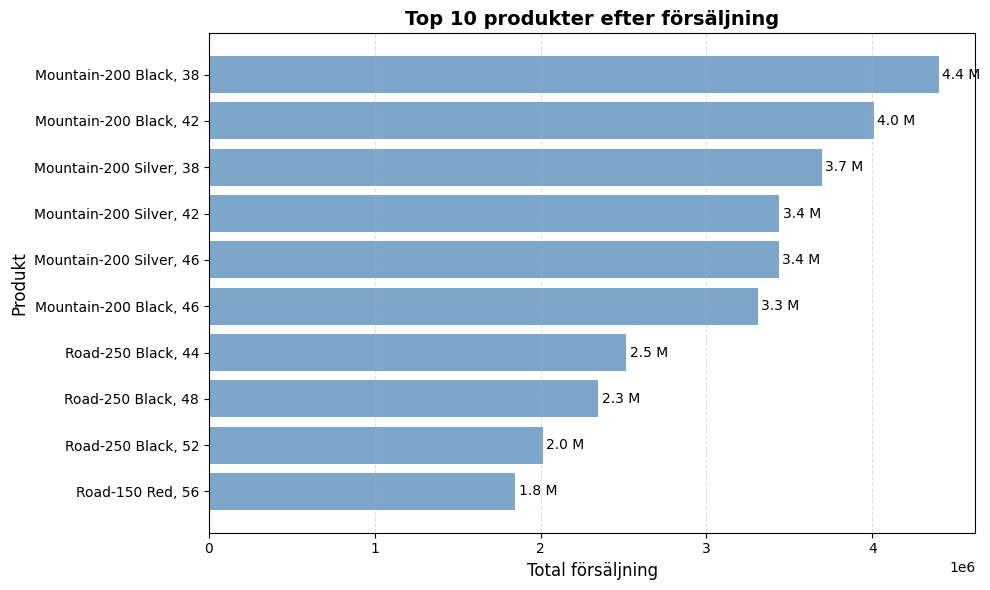

Produkten på plats 1 är: Mountain-200 Black, 38. Med en total försäljning på: $ 4,400,592.8004
Den Produktkategori som dominerar top 10 är: Bikes (10 av 10 produkter)


In [ ]:
# SQL-fråga: Hämtar topp 10 produkter baserat på total försäljning
query_vis5 = """
SELECT
    TOP 10
    p.Name AS ProductName,
    SUM(sod.LineTotal) AS TotalSales,
    pc.Name AS CategoryName
FROM Production.Product p  
INNER JOIN Sales.SalesOrderDetail sod ON p.ProductID = sod.ProductID
INNER JOIN Production.ProductSubcategory ps ON p.ProductSubcategoryID = ps.ProductSubcategoryID
INNER JOIN Production.ProductCategory pc ON ps.ProductCategoryID = pc.ProductCategoryID
GROUP BY p.ProductID, p.Name, pc.Name
ORDER BY TotalSales DESC
"""

# Kör SQL-frågan och lagrar resultatet i en DataFrame
df_vis5 = query_df(query_vis5)

# Skapar ett horisontellt stapeldiagram
fig, ax = plt.subplots(figsize=(10,6))
bars = ax.barh(df_vis5['ProductName'][::-1], df_vis5['TotalSales'][::-1], color='steelblue', alpha=0.7)

# Lägger värdeetiketter bredvid staplarna
autolabel_bars(ax, bars, orientation='horizontal', y_offset= 20_000)

# Titel, etiketter och layot
ax.set_title('Top 10 produkter efter försäljning', fontsize=14, fontweight='bold')
ax.set_xlabel('Total försäljning',fontsize=12)
ax.set_ylabel('Produkt', fontsize=12 )
ax.grid(axis='x',linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Identifierar vilken produktkategori som dominerar bland topp 10-produkterna
dominant_category = df_vis5['CategoryName'].value_counts().idxmax()
count = df_vis5['CategoryName'].value_counts().max()

# Skriver ut den mest sålda produkten (exakta siffror) samt vilken kategori som dominerar topp 10
print(f"Produkten på plats 1 är: {df_vis5.iloc[0]['ProductName']}. Med en total försäljning på: $ {df_vis5.iloc[0]['TotalSales']:,}")
print(f'Den Produktkategori som dominerar top 10 är: {dominant_category} ({count} av 10 produkter)')

### Insikter - Top 10 produkter

De 10 produkter som genererar mest försäljning är samtliga cyklar från kategorin **Bikes**, vilket tydligt visar att denna kategori är företagets absolut starkaste försäljningsområde.

- **Produkten på plats 1** är **Mountain-200 Black, 38** med en total försäljning ca **$ 4,4 miljoner**.  
  Den står ensam för över 10 % av den sammanlagda försäljningen från hela topp 10-listan. 

- Topp 10 domineras fullständigt av kategorin **Bikes** (100 % av produkterna).  
  Modellerna **Mountain-200** (6 av 10 platser) genererar tillsammans över 70% av topp 10-försäljningen.

**Sammanfattningsvis** visar analysen att **Mountain-200** är den ledande produktserien i AdventureWorks, både vad gäller antal produkter i toppskiktet och försäljningsvolym. Detta är värdefull information för affärsbeslut som rör lagerhantering, marknadsföring och produktutveckling.

Samtidigt innebär den starka koncentrationen till en enda modellfamilj en potentiell risk. Om det uppstår leveransproblem, kvalitetsbrister, ökad konkurrens eller förändrade kundpreferenser kring just denna serie kan det påverka företagets totala försäljning betydligt.

---

## Analys 6 - Försäljning och antal kunder per region
**Affärsfråga: Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?**

Tabeller som används: Sales.SalesTerritory, Sales.SalesOrderHeader, Sales.Customer

**Plan**
1. JOINA tabellerna för att hämta Regionsnamn och räkna ut totalsumman för varje region. Samt räkna antal unika CustomerID inom varje region
2. Göra om min Query till en Dataframe
3. Visualisera resultatet med Grupperat stapeldiagram
4. Analysera resultatet - Krav på insikt: **Vilken region är starkast/svagast? Jämför: Har regionen med högst försäljning också flest kunder, eller har de färre kunder med högre ordervärde? Vad betyder det?.**

,RegionName,TotalSales,TotalCustomers
0,Southwest,"24,184,610",4565
1,Canada,"16,355,770",1677
2,Northwest,"16,084,943",3428
3,Australia,"10,655,336",3625
4,Central,"7,909,009",69
5,Southeast,"7,879,655",91
6,United Kingdom,"7,670,721",1951
7,France,"7,251,556",1844
8,Northeast,"6,939,374",57
9,Germany,"4,915,408",1812


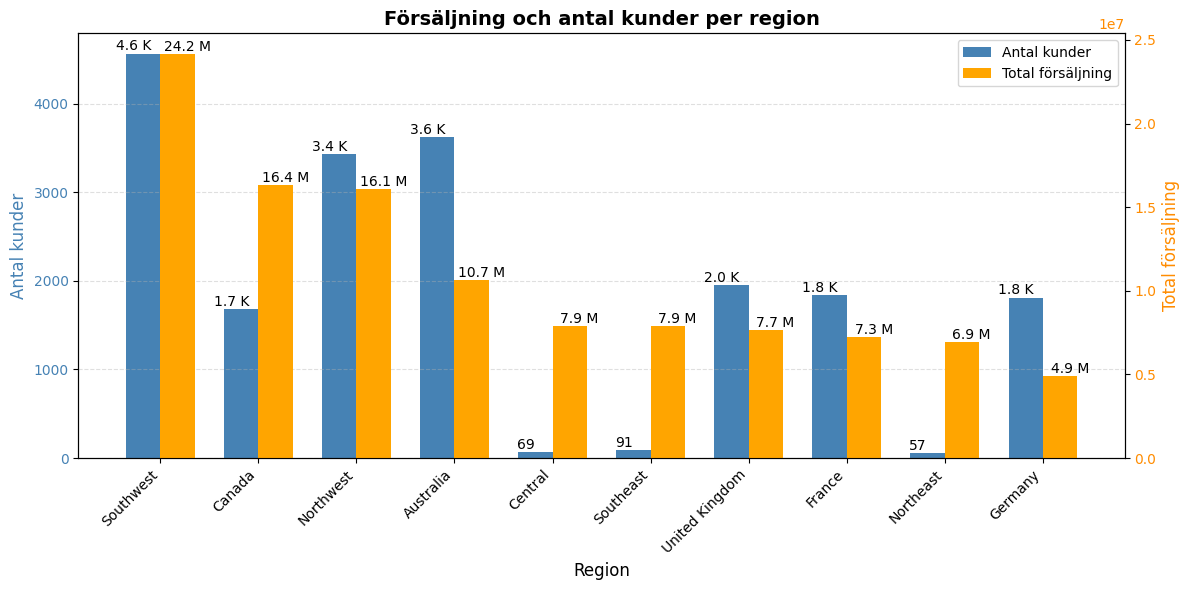

In [ ]:
# SQL-fråga: Total försäljning och unika kunder per region
query_vis6 = """
SELECT
    st.Name AS RegionName,
    SUM(soh.SubTotal) AS TotalSales,
    COUNT(DISTINCT c.CustomerID) AS TotalCustomers
FROM Sales.SalesTerritory st
INNER JOIN Sales.Customer c ON st.TerritoryID = c.TerritoryID
INNER JOIN Sales.SalesOrderHeader soh ON c.CustomerID = soh.CustomerID
GROUP BY st.Name
ORDER BY TotalSales DESC
"""
# Kör SQL-frågan och lagrar resultatet i en DataFrame
df_vis6 = query_df(query_vis6)

# Visar tabellen med formatterad försäljning för bättre läsbarhet
display(df_vis6.style.format({'TotalSales': '{:,.0f}'}))

# Data för diagrammet
regions = df_vis6['RegionName']         # x-axeln
customers = df_vis6['TotalCustomers']   # Stapel 1 - Antal kunder
sales = df_vis6['TotalSales']           # Stapel 2 - Total försäljning

# Positioner för grupperade staplar
x = np.arange(len(regions))
width = 0.35

# Skapa diagram med två y-axlar (olika skalor)
fig, ax1 = plt.subplots(figsize=(12,6))

# Stapel 1 - Antal kunder (vänster y-axel) 
bar_customer = ax1.bar(x - width/2, customers, width, label='Antal kunder', color='steelblue')
ax1.set_xlabel('Region', fontsize=12)
ax1.set_ylabel('Antal kunder', color='steelblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.set_xticks(x)
ax1.set_xticklabels(regions, rotation=45, ha='right')
ax1.grid(axis='y', linestyle='--', alpha=0.4)

# Stapel 2 - Total försäljning (höger y-axel)
ax2 = ax1.twinx()
bar_sales = ax2.bar(x + width/2, sales, width, label='Total försäljning', color='orange')
ax2.set_ylabel('Total försäljning', color='darkorange', fontsize=12)
ax2.tick_params(axis='y', labelcolor='darkorange')

# Lägger värdeetiketter över staplarna
autolabel_bars(ax1, bar_customer, orientation='vertical', x_offset=-0.1)
autolabel_bars(ax2, bar_sales, orientation='vertical', x_offset=0.1)

# Legend – kombinerar båda axlarna
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Titel och layout
plt.title('Försäljning och antal kunder per region', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Insikter - Försäljning och antal kunder per region

Analysen visar tydliga skillnader mellan regionerna

**Starkaste regionen är Southwest**, med överlägset högst total försäljning (ca $24,2 miljoner) och samtidigt flest unika kunder (4 565). Detta indikerar en stark kombination av hög kundvolym och bra genomsnittligt ordervärde.  
**Svagaste regionen är Germany**, med lägst försäljning (ca $4,9 miljoner), trots ett relativt högt antal kunder (1 812) – Detta tyder på ett lägre genomsnittligt ordervärde per kund jämfört med andra regioner.

Samtidigt finns regioner som Canada, Central, Southeast och Northeast som genererar hög försäljning trots få kunder, vilket indikerar högt genomsnittligt ordervärde och troligen större eller mer professionella kunder.

Sammantaget pekar analysen på behovet av olika strategier per region: kundvolym i starka marknader och fokus på kundvärde och kundlojalitet i regioner med färre men mer värdefulla kunder.

---

## Analys 7 - Genomsnittligt ordervärde per region och kundtyp
**Affärsfråga: Vilka regioner har högst/lägst genomsnittligt ordervärde, och skiljer det sig mellan individuella kunder och företagskunder?**


Tabeller som används: Sales.SalesTerritory, Sales.SalesOrderHeader, Sales.Customer

**Plan**
1. JOINA tabellerna för att hämta Regionsnamn, skapa en ny kolumn "CostumTyp" (Store vs Preson) med hjälp av "StoreID" samt beräkna total försäljning och antal ordrar per region och kundtyp.. 
2. Göra om min Query till en Dataframe
3. Beräkna genomsnittligt ordervärde (AOV) genom att dividera total försäljning med antal ordrar, samt strukturera och sortera datan per region och kundtyp för att möjliggöra jämförelse
4. Visualisera resultatet med Grupperat stapeldiagram
5. Analysera resultatet - Krav på insikt: **Vilken grupp har högre ordervärde? Skiljer det sig mellan regioner? Vad kan förklara skillnaderna? Vilken region + kundtyp-kombination har högst ordervärde?**

,RegionName,CustomType,TotalSales,OrderCount,AvgOrderValue
0,Australia,Store,"1,594,335",125,"12,755"
1,Australia,Person,"9,061,001",6718,"1,349"
2,Canada,Store,"14,377,926",692,"20,777"
3,Canada,Person,"1,977,845",3375,586
4,Central,Store,"7,906,008",376,"21,027"
5,Central,Person,"3,001",9,333
6,France,Store,"4,607,538",188,"24,508"
7,France,Person,"2,644,018",2484,"1,064"
8,Germany,Store,"2,021,095",139,"14,540"
9,Germany,Person,"2,894,312",2484,"1,165"


,RegionName,TotalSales,OrderCount,RegionAvg
0,Australia,1.065534e+07,6843,1557.114710
1,Canada,1.635577e+07,4067,4021.581130
2,Central,7.909009e+06,385,20542.880536
3,France,7.251556e+06,2672,2713.905557
4,Germany,4.915408e+06,2623,1873.964009
5,Northeast,6.939374e+06,352,19714.132049
6,Northwest,1.608494e+07,4594,3501.293546
7,Southeast,7.879655e+06,486,16213.282043
8,Southwest,2.418461e+07,6224,3885.702057
9,United Kingdom,7.670721e+06,3219,2382.951549


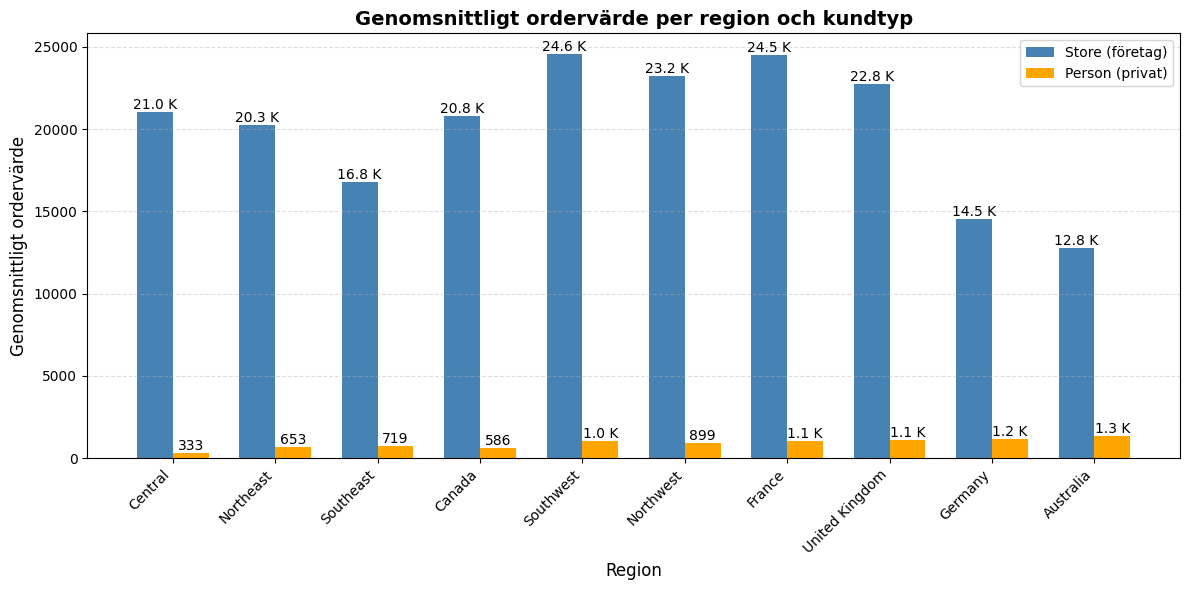

In [ ]:
# SQL-fråga: Total försäljning och antal ordrar per region och kundtyp (Store vs Person)
query_vis7 = """
SELECT
    st.Name AS RegionName,
    CASE 
        WHEN c.StoreID IS NOT NULL THEN 'Store'
        ELSE 'Person'
    END AS CustomType,
    SUM(soh.SubTotal) AS TotalSales,
    COUNT(*) AS OrderCount
FROM Sales.SalesTerritory st  
INNER JOIN Sales.Customer c ON st.TerritoryID = c.TerritoryID
INNER JOIN Sales.SalesOrderHeader soh ON c.CustomerID = soh.CustomerID
GROUP BY st.Name, 
         CASE WHEN c.StoreID IS NOT NULL THEN 'Store' ELSE 'Person' END
ORDER BY st.Name, CustomType DESC
"""

# Kör SQL-frågan och lagrar resultatet i en DataFrame
df_vis7 = query_df(query_vis7)

# Beräknar genomsnittligt ordervärde (AOV) per region och kundtyp
df_vis7['AvgOrderValue'] = df_vis7['TotalSales'] / df_vis7['OrderCount']

# Visar data med formatterade värden för bättre läsbarhet
display(df_vis7.style.format({'TotalSales': '{:,.0f}','AvgOrderValue': '{:,.0f}'}))

# Aggregerar total försäljning och antal ordrar per region
region_totals = df_vis7.groupby('RegionName').agg({
    'TotalSales': 'sum',
    'OrderCount': 'sum'
}).reset_index()

# Beräknar genomsnittligt ordervärde per region (oavsett kundtyp)
region_totals['RegionAvg'] = region_totals['TotalSales'] / region_totals['OrderCount']
display(region_totals)

# Sorterar regionerna efter totalt genomsnittligt ordervärde (högst först)
region_order = region_totals.sort_values('RegionAvg', ascending=False)['RegionName']

# Delar upp data i separata DataFrames för företagskunder (Store) och privatkunder (Person)
df_store = df_vis7[df_vis7['CustomType'] == 'Store'].set_index('RegionName')
df_person = df_vis7[df_vis7['CustomType'] == 'Person'].set_index('RegionName')

# Data för diagrammet
regions = region_order                                      # x-axel
store_values = df_store.loc[regions]['AvgOrderValue']       # Stapel 1 "Store"
person_values = df_person.loc[regions]['AvgOrderValue']     # Stapel 2 "Person"

# Positioner för grupperade staplar
x = np.arange(len(regions))
width = 0.35

# Skapa grupperat stapeldiagram
fig, ax = plt.subplots(figsize=(12,6))

# Stapel 1 - Store (företag)
bars_store = ax.bar(x - width/2, store_values, width, label='Store (företag)', color='steelblue')
# Stapel 2 - Person (privat)
bars_person = ax.bar(x + width/2, person_values, width, label='Person (privat)', color='orange')

# Lägger värdeetiketter över staplarna
autolabel_bars(ax, bars_store, orientation='vertical')
autolabel_bars(ax, bars_person, orientation='vertical')

# Titel, etiketter och layout
ax.set_xlabel('Region', fontsize=12)
ax.set_ylabel('Genomsnittligt ordervärde', fontsize=12)
ax.set_title('Genomsnittligt ordervärde per region och kundtyp',fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(regions, rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.4)
ax.legend()
plt.tight_layout()
plt.show()

### Insikter - Genomsnittligt ordervärde per region och kundtyp

**1. Vilken grupp har högre ordervärde**  
Det är en mycket tydlig skillnad mella kundgrupperna. 
* **Store** (företagskunder) har ett avsevärt högre genomsnittligt ordervärde än **Person** (privatkunder) i samtliga regioner.  
* Privatpersoners genomsnittliga ordervärde ligger generellt under $1.500 medan företagskunder ofta ligger mellan $15.000-$25.000

**2. Skiljer det sig mellan regionerna**  
Ja, det finns geografiska skillnader.
* **Högst värde** (Store) finns i **Southwest**, **France** och **Northwest** där snittet är över $23.000 per order
* **Lägst värde** (Store) finns i **Australia** och **Germany** där snittet ligger runt $12 000 – $14 000, vilket är nästan hälften av topparna.
* För **Privatpersoner** är skillnaderna mindre överlag, men man ser ändå vissa skillnader. **Australia** har t.ex. ett relativt högt snitt för privatpersoner ($1 348) jämfört med **Central** ($333).

**3. Vad kan förklara skillnaderna**
* Företagskunder gör sannolikt större inköp i form av lagerpåfyllnad eller återförsäljning, medan privatpersoner köper enstaka produkter, vilket förklarar den stora skillnaden i ordervärde.
* Australia sticker ut genom ett mycket högt antal privatkundsordrar (6 718 st) men lägre genomsnitt per företagsorder, vilket tyder på en marknad med stark direktförsäljning till konsument snarare än stora bulkinköp

**4. Högsta ordervärde (region + kundtyp)**  
* Den högsta kombinationen av genomsnittligt ordervärde återfinns hos Store-kunder i Southwest.

---


# Djupanalys - Regional försäljningsoptimering 

•	Vilken region presterar bäst/sämst?  
•	Vilka produktkategorier säljer bäst var?  
•	Finns säsongsmönster per region?  


## Djupanalys 1 - Regional försäljningsoptimering
**Affärsfråga: Vilken region presterar bäst/sämst**


Tabeller som används: Sales.SalesTerritory, Sales.SalesOrderHeader, Sales.Customer

**Plan**
1. JOINA tabellerna för att hämta Regionsnamn, samt beräkna total försäljning och antal ordrar per region. 
2. Göra om min Query till en Dataframe
3. Visa DataFrame med totalförsäljning och antal ordrar för att kunna göra djupare analys av försäljningen.
3. Visualisera resultatet med stapeldiagram
4. Analysera resultatet - Krav på insikt: **Vilken region presterar bäst/sämst**

,RegionName,TotalSales,OrderCount
0,Southwest,"24,184,610",6224
1,Canada,"16,355,770",4067
2,Northwest,"16,084,943",4594
3,Australia,"10,655,336",6843
4,Central,"7,909,009",385
5,Southeast,"7,879,655",486
6,United Kingdom,"7,670,721",3219
7,France,"7,251,556",2672
8,Northeast,"6,939,374",352
9,Germany,"4,915,408",2623


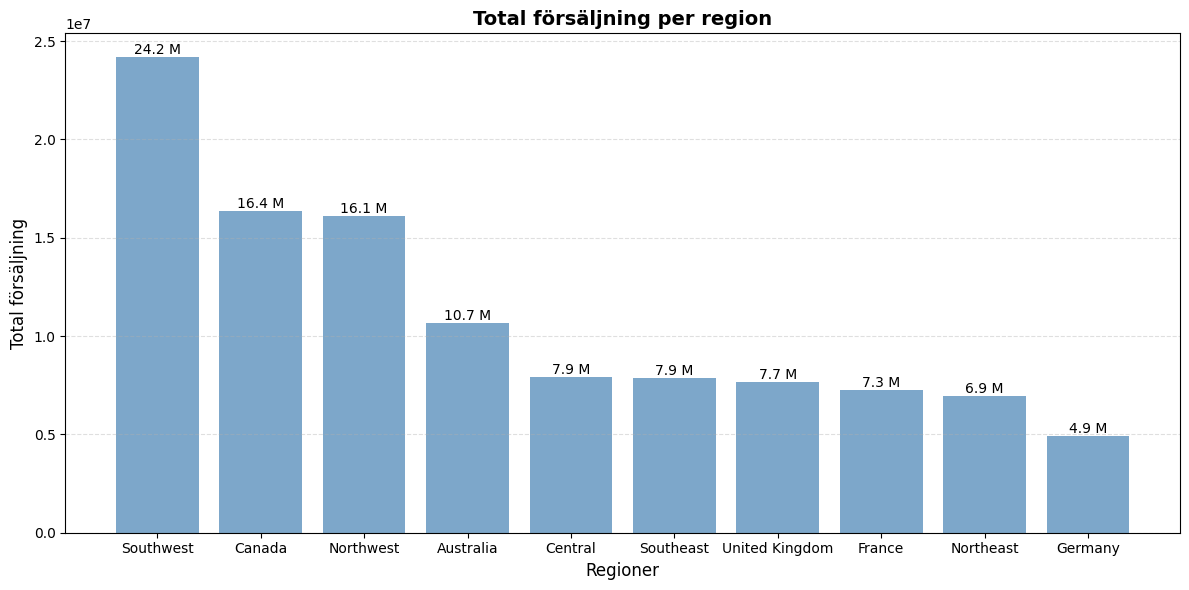

In [ ]:
# SQL-fråga: Total försäljning och antal ordrar per region
query_deep_vis1 = """
SELECT
    st.Name AS RegionName,
    SUM(soh.SubTotal) AS TotalSales,
    COUNT(DISTINCT soh.SalesOrderID) AS OrderCount
FROM Sales.SalesTerritory st
INNER JOIN Sales.Customer c ON st.TerritoryID = c.TerritoryID
INNER JOIN Sales.SalesOrderHeader soh ON c.CustomerID = soh.CustomerID
GROUP BY st.Name
ORDER BY TotalSales DESC
"""

# Kör SQL-frågan och lagrar resultatet i en DataFrame
df_deep_vis1 = query_df(query_deep_vis1)

# Visa tabellen med formaterad total försäljning för bättre läsbarhet
display(df_deep_vis1.style.format({'TotalSales': '{:,.0f}'}))

# Skapar vertikalt stapeldiagram
fig, ax = plt.subplots(figsize=(12,6))
bars = ax.bar(df_deep_vis1['RegionName'], df_deep_vis1['TotalSales'], color='steelblue', alpha=0.7)

# Lägger värdeetiketter ovanpå staplarna
autolabel_bars(ax, bars, orientation= 'vertical')

# Titel, etiketter och Layout
ax.set_title('Total försäljning per region', fontsize=14, fontweight='bold')
ax.set_xlabel('Regioner',fontsize=12)
ax.set_ylabel('Total försäljning', fontsize=12 )
ax.grid(axis='y',linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### Insikter - Vilken region presterar bäst/sämst

**Bäst/sämst**
* **Southwest** är den solklara ledaren med över 24 miljoner i total försäljning. Det är intressant att notera att de inte har flest ordrar, men ändå högst omsättning.  
* **Germany** ligger i botten med ca 4,9 miljoner, vilket är ca en femtedel av Southwest's försäljning.
  
**Avvikelse**: 
* **Australia** utmärker sig med flest ordrar (6 843 st) men ligger bara på fjärde plats i total försäljning. (detta visades även i Anlys 7 där vi såg att Australia har många privatpersoner och färre företag) 
* Regioner som **Central**, **Southeast** och **Northeast** har extremt låga orderantal (under 500 st). Detta tyder på att dessa marknader antingen är nystartade eller att man har svårt att nå ut till kunderna där, till skillnad från t.ex. Canada eller Northwest.

**Utvärdering**:  
Eftersom Southwest genererar störst kassaflöde bör man undersöka vad som gör dem framgångsrika – är det sortimentet, marknadsföringen eller säljteamet? Samtidigt bör man utvärdera om Germany kräver en ny strategi då de presterar sämst trots att de har ett relativt högt antal ordrar (2 623 st).

---


## Djupanalys 2 - Regional försäljningsoptimering
**Affärsfråga: Vilka produktkategorier säljer bäst var?**


Tabeller som används: Sales.SalesTerritory, Sales.SalesOrderHeader, Sales.Customer, Production.ProductCategory, Production.ProductSubcategory, Production.Product, Sales.SalesOrderDetail

**Plan**
1. JOINA tabellerna för att hämta Regionsnamn, Kategori samt beräkna total försäljning per region och kategori. 
2. Göra om min Query till en Dataframe
3. Visualisera resultatet med heatmap
5. Analysera resultatet - Krav på insikt: **Vilka produkter säljer bäst var**

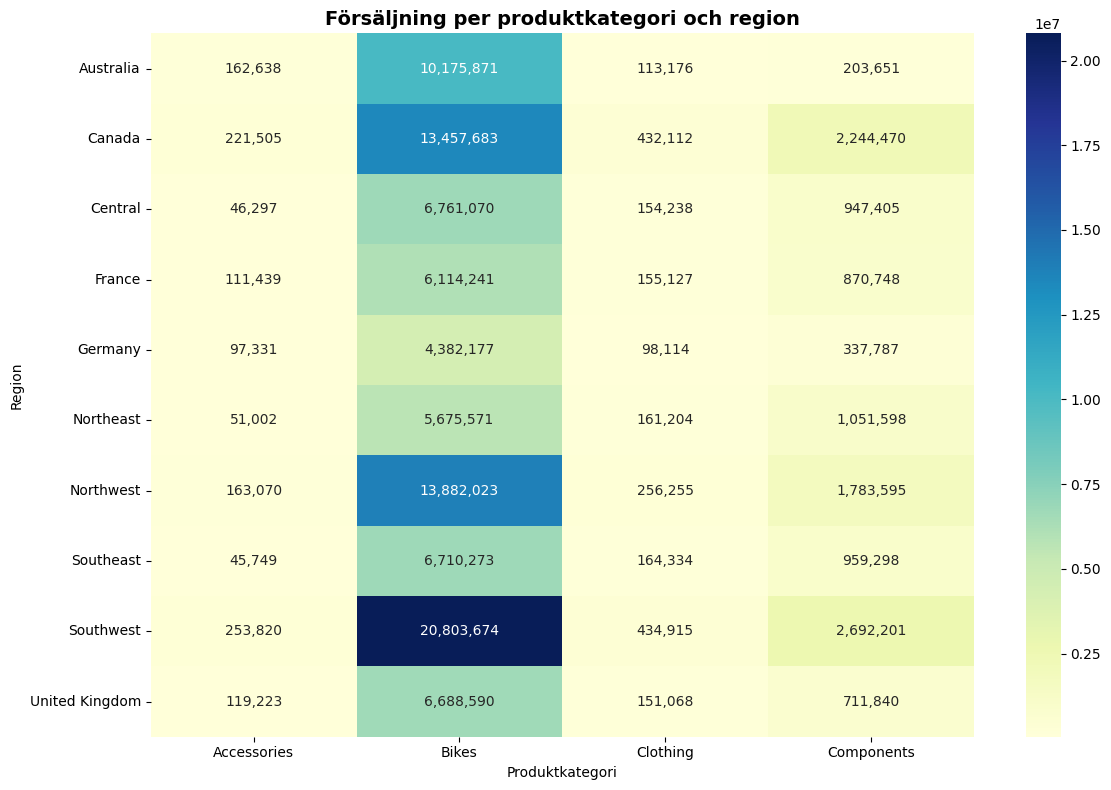

In [ ]:
# SQL-fråga: Försäljning uppdelat på region och produktkategori
query_deep_vis2 = """
SELECT
    st.Name AS RegionName,
    pc.Name AS Category,
    SUM(sod.LineTotal) AS LineTotal
FROM Sales.SalesTerritory st  
INNER JOIN Sales.Customer c ON st.TerritoryID = c.TerritoryID
INNER JOIN Sales.SalesOrderHeader soh ON c.CustomerID = soh.CustomerID
INNER JOIN Sales.SalesOrderDetail sod ON soh.SalesOrderID = sod.SalesOrderID
INNER JOIN Production.Product p ON sod.ProductID = p.ProductID
INNER JOIN Production.ProductSubcategory ps ON p.ProductSubcategoryID = ps.ProductSubcategoryID
INNER JOIN Production.ProductCategory pc ON ps.ProductCategoryID = pc.ProductCategoryID
GROUP BY st.Name, pc.Name
"""

# Kör SQL-frågan och lagrar resultatet i en DataFrame
df_deep_vis2 = query_df(query_deep_vis2)

# Skapar pivot-tabell för att strukturera data för heatmap
pivot_deep_vis2 = df_deep_vis2.pivot(index='RegionName', columns='Category', values='LineTotal').fillna(0)

# Skapar heatmap för att visualisera regionala försäljningsmönster
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(pivot_deep_vis2, annot=True, fmt=',.0f', cmap='YlGnBu', ax=ax)

# Titel, etiketter och Layout
ax.set_title('Försäljning per produktkategori och region', fontsize=14, fontweight='bold')
ax.set_xlabel('Produktkategori')
ax.set_ylabel('Region')
plt.tight_layout()
plt.show()

### Insikter - Vilka produkter säljer bäst var?

* **Dominerande kategori**: "Bikes" är den absolut största intäktskällan i samtliga regioner. Den mörkblå färgen i Southwest (ca 20,8 miljoner) visar att detta är företagets kärnprodukt och starkaste marknad.

* **Sekundära kategorier**: "Components" är den näst största kategorin generellt, med särskilt stark försäljning i Southwest (2,7 miljoner) och Canada (2,2 miljoner). Intressant att notera är att Canada har en relativt hög försäljning av komponenter trots att deras totala cykelförsäljning är lägre än i t.ex. Northwest. Detta tyder på en stark eftermarknad eller reparationskultur i Canada..

* **Lågpresterande kategorier**: "Accessories" och "Clothing" genererar konsekvent lägst intäkter i alla regioner. 

**Sammanfattande insikter**:  
Företaget är starkt beroende av cykelförsäljning, vilket kan innebära en risk om marknaden mättas eller förändras.  
För att öka **Merförsäljningen** bör man genomföra en analys av varför "Accessories" presterar så lågt. En rekommendation är att paketera tillbehör vid cykelköp för att höja snittordervärdet, särskilt i högvolymsregioner som Southwest och Northwest   
Efterson Components redan säljer bra i Canada och Southwest kan det vara värt att stärka Components ytterligare genom riktade kampanjer för att driva upp maginalerna där.

---

## Djupanalys 3 - Regional försäljningsoptimering
**Affärsfråga: Finns säsongsmönster per region?**


Tabeller som används: Sales.SalesTerritory, Sales.SalesOrderHeader, Sales.Customer.

**Plan**
1. JOINA tabellerna för att hämta Regionsnamn, formatera om OrderDate för att kunna sortera på år och månad samt summera total försäljning.
2. Göra om min Query till en Dataframe
3. Visualisera med ett Facet Grid av linjediagram för att kunna jämföra säsongsmönster mellan samtliga regioner parallellt.
4. Skapa pivot data av 2024 för att visualisera med heatmap för djupare analys
5. Analysera resultatet - Krav på insikt: **Finns säsongsmönster per region?**

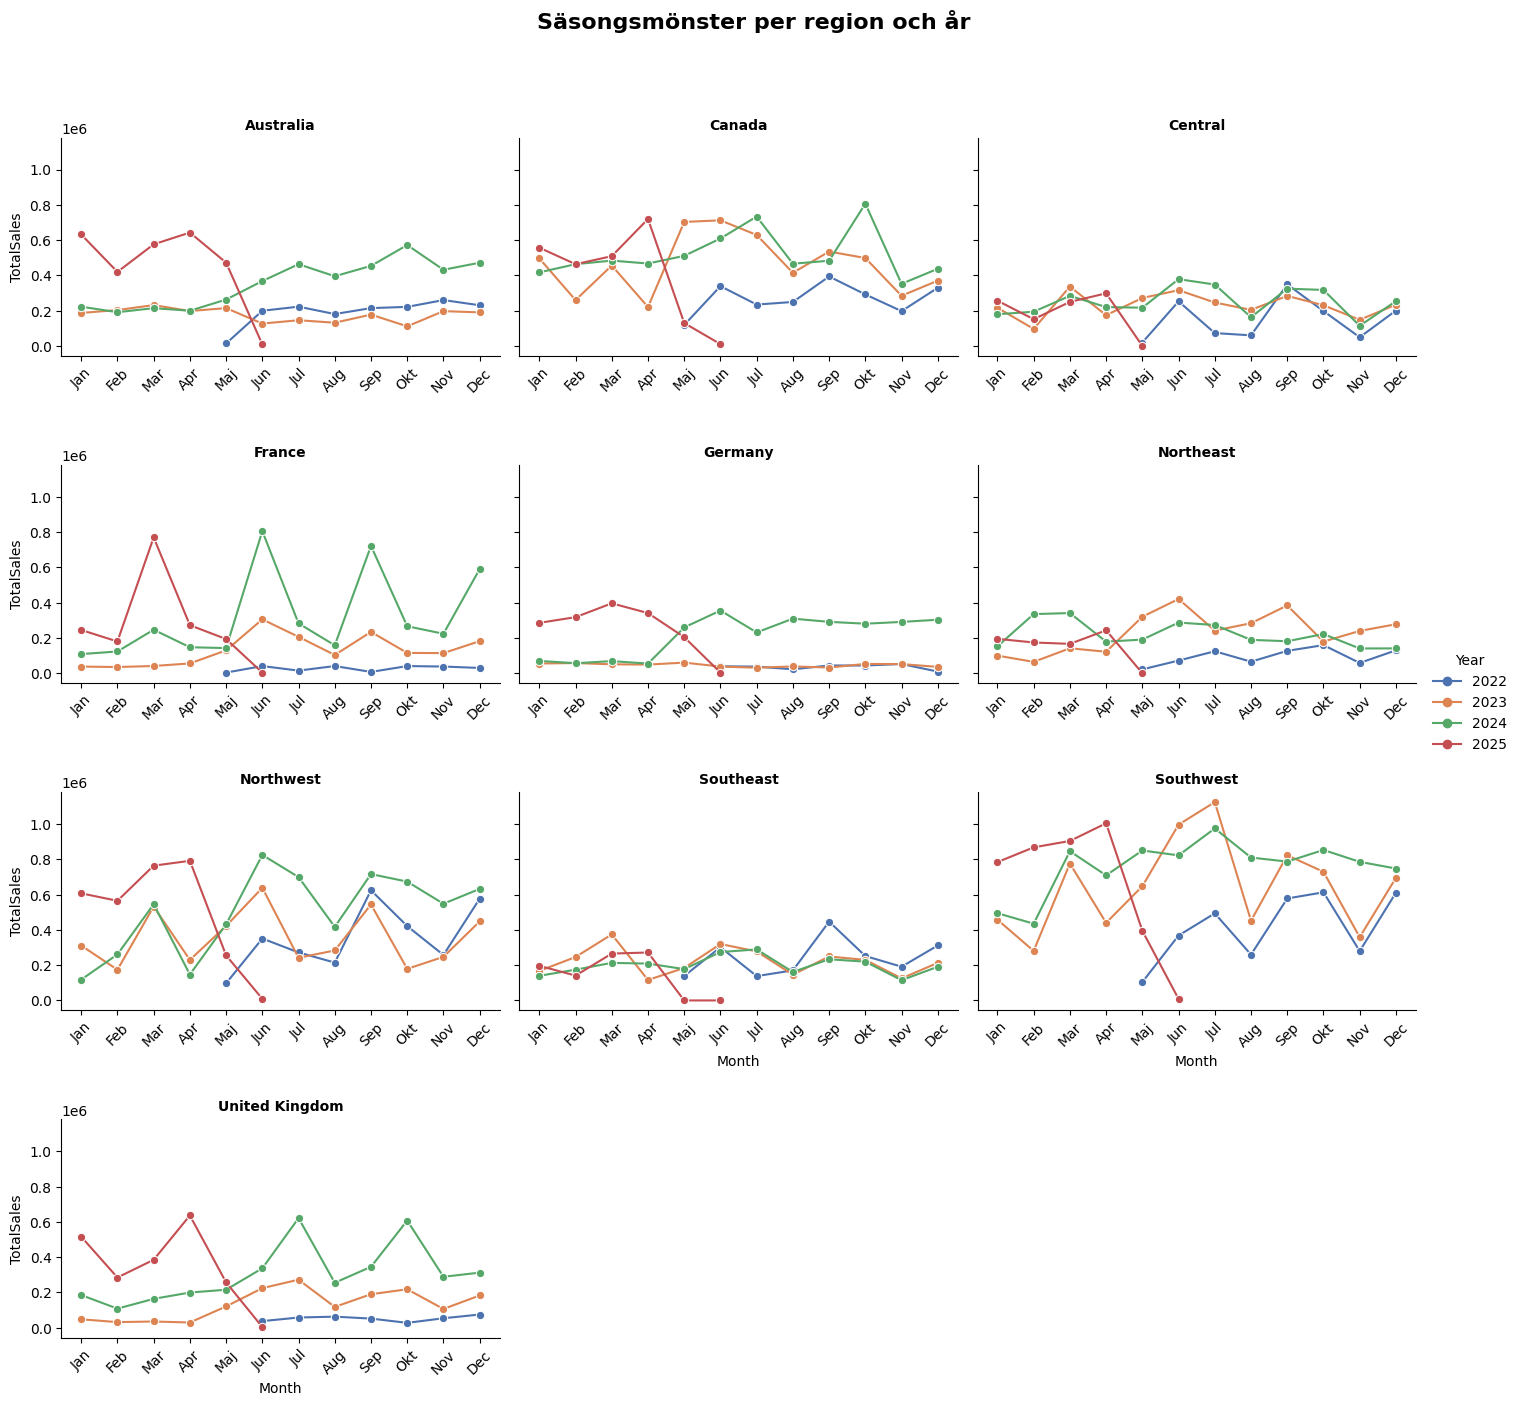

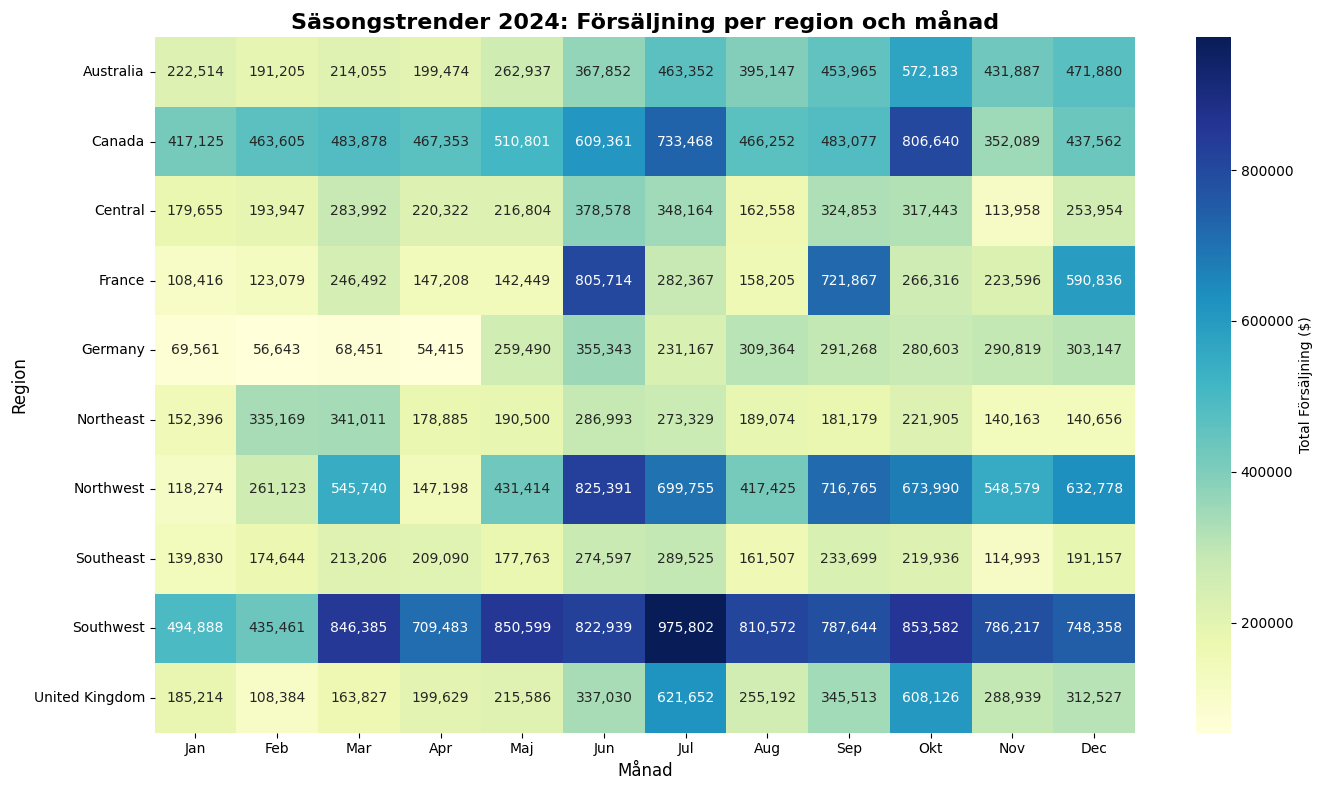

In [ ]:
# SQL-fråga: Total försäljning per månad för varje region
query_deep_vis3 = """
SELECT
    st.Name AS RegionName,
    DATEFROMPARTS(YEAR(soh.OrderDate), MONTH(soh.OrderDate), 1) AS YearMonth,
    SUM(soh.SubTotal) AS TotalSales
FROM Sales.SalesTerritory st  
INNER JOIN Sales.Customer c ON st.TerritoryID = c.TerritoryID
INNER JOIN Sales.SalesOrderHeader soh ON c.CustomerID = soh.CustomerID
GROUP BY st.Name, YEAR(OrderDate), MONTH(OrderDate)
ORDER BY RegionName,YearMonth
"""
# Kör SQL-frågan och lagrar resultatet i en DataFrame
df_deep_vis3 = query_df(query_deep_vis3)

# Förbereder data för att analysera säsongsmönster genom att dela upp datum i år och månad
df_deep_vis3['YearMonth'] = pd.to_datetime(df_deep_vis3['YearMonth'])
df_deep_vis3['Year'] = df_deep_vis3['YearMonth'].dt.year
df_deep_vis3['Month'] = df_deep_vis3['YearMonth'].dt.month

# Skapar FacetGrid för att jämföra säsongsmönster mellan år per region
g = sns.relplot(
    data=df_deep_vis3, 
    x='Month', y='TotalSales', 
    hue='Year', col='RegionName', 
    kind='line', marker='o', 
    col_wrap=3, height=4, aspect=1.2,
    palette='deep'
    )

# Säkerställer att alla axlar har månader synliga
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)

# Justerar mellanrum mellan graferna
g.figure.subplots_adjust(bottom=0.15, hspace=0.5)

# Titel, etiketter och Layout
g.figure.suptitle('Säsongsmönster per region och år', fontsize=16, fontweight='bold')
g.set_titles("{col_name}", weight='bold')
g.set(xticks=range(1, 13))
g.set_xticklabels(['Jan','Feb','Mar','Apr','Maj','Jun','Jul','Aug','Sep','Okt','Nov','Dec'], rotation=45)

plt.subplots_adjust(top=0.9)
plt.show()

# Förbereder data och pivot-tabell för heatmap. 
df_2024 = df_deep_vis3[df_deep_vis3['Year'] == 2024]
pivot_all_regions = df_2024.pivot(index='RegionName', columns='Month', values='TotalSales').fillna(0)

# Namnge månaderna för tydlighet i Heatmapen
month_names = ['Jan','Feb','Mar','Apr','Maj','Jun','Jul','Aug','Sep','Okt','Nov','Dec']
pivot_all_regions.columns = month_names

# Skapar en heatmap för 2024 för tydligare säsongstrender
fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(pivot_all_regions, annot=True, fmt=',.0f', cmap='YlGnBu', cbar_kws={'label': 'Total Försäljning ($)'})

# Titel, etiketter och Layout
ax.set_title('Säsongstrender 2024: Försäljning per region och månad', fontsize=16, fontweight='bold')
ax.set_xlabel('Månad', fontsize=12)
ax.set_ylabel('Region', fontsize=12)

plt.tight_layout()
plt.show()

### Insikter - Finns säsongsmönster per region?

Analysen visar tydliga säsongsmönster som varierar beroende på geografisk marknad. Försäljningen är sällan linjär utan man kan se tydliga toppar och dalar. Facet grid-diagrammen visar en generell tillväxt från 2022 till 2024, följt av troligen ofullständiga data 2025.

**Heatmap för 2024**
Då 2024 identifierades som det mest kompletta och högpresterande året i Facet Gridet, valde jag detta år ut för en Pivot-tabell och Heatmap. Syftet är att kunna avläsa exakta säljtoppar per region.

Heatmapen synliggör att "säsong" betyder olika saker beroende på geografi:

* **Southwest**: Företagets motor – hög försäljning året runt med tydlig topp i juli (~975k).

* **Norra halvklotet** (France, Northwest, United Kingdom, Canada): Starka peaks under sommar och tidig höst med tydliga dippar mellan, framför allt i augusti och november.

* **Australien**: Omvänt mönster med högsta försäljning mot slutet av året – topp i oktober (~572k), i linje med deras vårsäsong.

* **Germany**: Jämn försäljning (~50–70k) men en markant uppgång från maj 2024 och framåt (~230–355k). 

* **Lägre volymregioner** (Central, Northeast, Southeast): Ojämna och generellt låga värden utan tydliga säsongstoppar.

Mönstren drivs troligen av väder (cykelsäsong) och lokala faktorer, med 4–6 månaders koncentration i de flesta regioner.  
**Rekommendation**: Anpassa kampanjer och lager regionalt – sommarfokus i Frankrike/Northwest/UK/Canada, höst(sep-nov) i Australien, och året-runt-stöd i Southwest

---

## Reflektion - Regional försäljningsoptimering

**Varför valde du regional försäljningsoptimering?**
Jag valde detta alternativ eftersom de inledande analyserna visade stora skillnader mellan regioner. Dessa skillnader indikerade att företagets intäkter inte drivs jämnt över marknaderna, vilket gör regionanalys central för affärsutveckling.
Genom att analysera regionerna ur flera perspektiv – total prestation, produktmix och säsongsvariationer – blev det möjligt att identifiera både starka och svaga marknader samt förstå var, när och hur försäljningen skapas. Denna typ av analys ger ett konkret beslutsunderlag för att rikta marknadsföring, kampanjer och resursallokering mer effektivt per region

**Varför valde du att göra aggregering i SQL vs pandas?**
Jag använde SQL för att effektivt JOINA stora tabeller och utföra den primära aggregeringen (SUM, COUNT). Genom att summera och gruppera redan i queryn minskas datamängden som skickas till pandas, vilket ger snabbare utförande och lägre minnesanvändning. Pivot-tabeller och mindre justeringar gjorde jag sedan i pandas för ha mer flexibilitet vid visualiseringarna.

**Varför valde du dessa typer av diagram för djupanalysen?**
- Vanligt stapeldiagram för total försäljning per region – enkelt och direkt.
- Heatmap valde jag för att snabbt identifiera mönster i stora datamängder (kategorier och månader). 
- Linjediagram (Facet Grid) tycker jag blev ett tydligt sätt att visualisera tidstrender över flera år och regioner samtidigt. 
För att sedan dyka djupare valde jag att även göra en Heatmap på 2024 så jag tydligt kunde se säsongsmönstret av försäljning i varje region.

**Hur hjälpte pivot tables dig att se mönster i data?**
Pivot-tabellen i Djupanalys 2 och 3 gjorde det möjligt att gå från rådata till insikter på ett strukturerat sätt. Utan pivot-funktionen i Pandas hade det varit mycket svårt att t.ex. se att Frankrike peakar i juni medan Kanada peakar i oktober.

**Vilka utmaningar stötte du på och hur löste du dem?**
En av de största utmaningarna i djupanalysen var att hitta visualiseringar som både visade helheten och samtidigt gjorde det möjligt att identifiera detaljerade mönster. Exempelvis blev mitt initiala linjediagram med alla regioner i samma graf svårlästa, vilket gjorde det svårt att dra tydliga slutsatser om säsongsmönster.

Jag valde då att använda Facet Grid uppdelt på regioner men stötte på visualiseringsproblem även här. Inledningsvis visades månaderna endast under de nedersta diagrammen, vilket försvårade tolkningen. För att förbättra tydligheten behövde jag justera layouten så att alla diagram fick samma information utan att det blev för trångt mellan rubriker och axlar. Detta krävde flera justeringar och tester innan jag hittade en balans som fungerade visuellt.

Trots att Facet Grid gav en bra överblick över säsongsmönster per region upplevde jag fortfarande svårigheter med att läsa av exakta värden. För att fördjupa analysen ytterligare valde jag därför att komplettera med en heatmap för år 2024. Heatmapen gjorde det enklare att snabbt identifiera toppar och dalar i datan och gav en tydligare bild av mönster mellan månader och regioner.

Sammanfattningsvis bestod de största utmaningarna i att välja rätt visualisering för rätt syfte. Genom att testa, utvärdera och justera olika metoder utvecklade jag både min förståelse för datan och min förmåga att använda visualiseringar på ett mer analytiskt och genomtänkt sätt.

---

## Sammanfattning – Regional försäljningsoptimering

Denna djupanalys har undersökt regional försäljning ur tre perspektiv: total prestation och ordervolym, produktkategoriernas fördelning per region samt säsongsmönster över tid. Tillsammans ger analyserna en helhetsbild av vilka marknader som driver intäkterna, varför de gör det och när försäljningen är som starkast.

Analysen visar att Southwest är företagets starkaste region sett till total försäljning, trots att regionen inte har flest ordrar. Detta indikerar ett högt genomsnittligt ordervärde, troligen drivet av en hög andel företagskunder och en stark försäljning av cyklar. Germany identifieras som den svagaste regionen, vilket pekar på behov av strategiska åtgärder för att öka försäljningen.

Produktanalysen visar att Bikes dominerar intäkterna i samtliga regioner, vilket innebär ett tydligt beroende av en produktkategori. Sekundära kategorier som Components presterar relativt starkt i vissa regioner (exempelvis Canada), medan Accessories och Clothing konsekvent har låg försäljning – en outnyttjad potential för merförsäljning.  

Slutligen visar säsongsanalysen att försäljningen är starkt kopplad till geografiska och klimatmässiga faktorer. Regioner på norra halvklotet uppvisar tydliga sommarpeakar, medan Australien har ett omvänt mönster.

**Rekommendationer**
- Lär av Southwest (hög volym året runt) och sprid dess framgångsfaktorer till andra regioner.  
- Minska beroendet av cykelförsäljning genom att öka fokuset på Components i starka marknader som Canada och Southwest.  
- Driv merförsäljning av Accessories/Clothing genom paketering med cykelköp.  
- Anpassa lager och kampanjer efter lokala säsonger.  
- Utvärdera och förstärk insatserna i svagare regioner som Germany och lågvolymområden (Central, Northeast, Southeast).

Genom regionalt anpassade strategier kan AdventureWorks både stärka befintliga starka marknader och lyfta underpresterande regioner.
